In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import tensorflow as tf

2025-06-30 11:02:13.757751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751306533.908579  827147 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751306533.953824  827147 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751306534.269711  827147 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751306534.269779  827147 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751306534.269782  827147 computation_placer.cc:177] computation placer alr

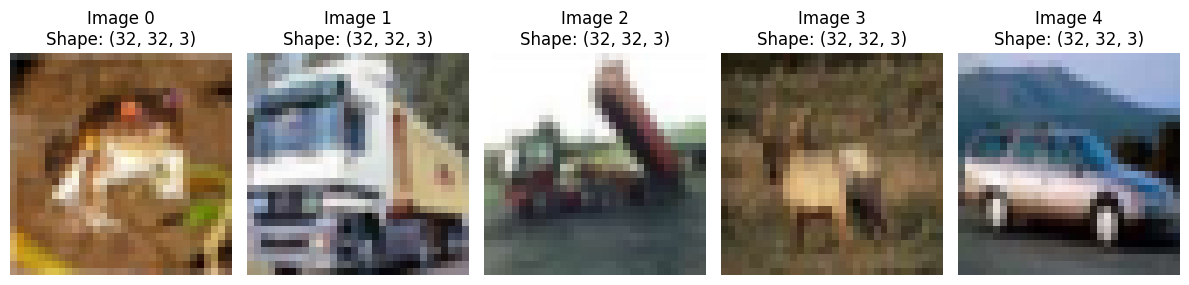

In [21]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

def unpickle(file):
    with open(file, 'rb') as fo:
        dict_data = pickle.load(fo, encoding='latin1')
    return dict_data

cifar_folder = 'cifar10'
batch_file = 'data_batch_1'

# Load batch
batch_path = os.path.join(cifar_folder, batch_file)
batch = unpickle(batch_path)

# Extract and reshape images
images = batch['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # shape (10000, 32, 32, 3)

# Plot first 5 images
plt.figure(figsize=(12, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"Image {i}\nShape: {images[i].shape}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt



# --- DAE Definition with Channel Dimension Support ---
def create_dae(input_shape):
    def renormalize(x):
        x_sum = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True)
        x = x / (x_sum + 1e-8) * 8.0
        return x
    flat_dim = np.prod(input_shape)
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        
        # Encoder
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        
        # Decoder
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(flat_dim, activation='sigmoid'),
        layers.Reshape(target_shape=input_shape),
        layers.Lambda(renormalize)
    ])
    return model

# --- Main Execution ---
if __name__ == '__main__':
    input_shape = (64, 64, 1)


    dae = create_dae(input_shape)
    # change loss to JS div
    custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    dae.compile(optimizer=custom_optimizer, loss=jensen_shannon_divergence_loss)

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    dae.fit(x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=100,
            batch_size=50,
            callbacks=[early_stop],
            verbose=1)

    # --- Predict and Evaluate ---
    i = 0
    denoised_norm = dae.predict(x_test[i:i+1])[0, ..., 0]
    denoised = denoised_norm
    noisy_input = x_test[i, ..., 0]
    true_clean = y_test

    # --- Plot ---
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(noisy_input, cmap='viridis')
    plt.title("Noisy Input")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(denoised, cmap='viridis')
    plt.title("Denoised Output")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(true_clean[0,:,:,0], cmap='viridis')
    plt.title("Clean Target")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


    
    

I0000 00:00:1751306916.790849  827147 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 890 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


NameError: name 'jensen_shannon_divergence_loss' is not defined